   Crop_Type Best_Order (p,d,q)        AIC        BIC     LogLik
0    Soybean          (0, 0, 1)  25.131398  26.039153  -9.565699
1     Tomato          (2, 1, 1)  25.752046  26.540945  -8.876023
2     Potato          (0, 0, 1)  29.943170  30.850925 -11.971585
3     Barley          (0, 1, 0)  30.492479  30.689704 -14.246240
4  Sunflower          (0, 0, 1)  31.451690  32.359445 -12.725845
5       Corn          (1, 2, 0)  31.572088  31.730971 -13.786044
6  Sugarcane          (1, 1, 0)  33.338000  33.732449 -14.669000
7      Wheat          (1, 0, 2)  33.418679  34.931605 -11.709340
8     Cotton          (0, 1, 0)  34.885432  35.082656 -16.442716
9       Rice          (2, 2, 0)  37.599108  37.837432 -15.799554
Tomato 2023-12-31 00:00:00: 22.49 (95% Confidence Interval (CI): 21.46 – 23.53)
Tomato 2024-12-31 00:00:00: 24.00 (95% Confidence Interval (CI): 22.94 – 25.05)
Tomato 2025-12-31 00:00:00: 22.82 (95% Confidence Interval (CI): 21.58 – 24.05)
Wheat 2023-12-31 00:00:00: 25.11 (95% Confide

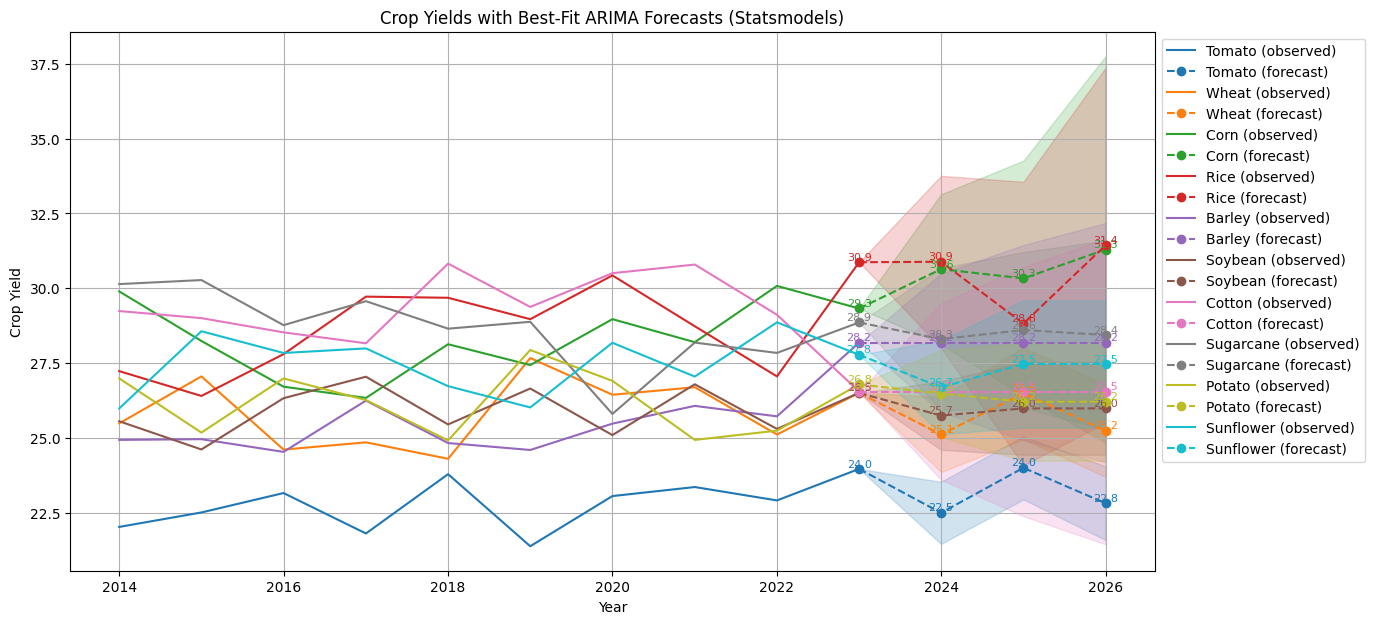

                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                   10
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -12.726
Date:                Mon, 22 Sep 2025   AIC                             31.452
Time:                        12:49:16   BIC                             32.359
Sample:                    01-01-2014   HQIC                            30.456
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4705      0.104    263.583      0.000      27.266      27.675
ma.L1         -0.9999   1127.812     -0.001      0.999   -2211.471    2209.471
sigma2         0.5872    662.372      0.001      0.9

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import itertools

warnings.filterwarnings("ignore")

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month

crops = ["Tomato", "Wheat", "Corn", "Rice", "Barley", "Soybean", "Cotton", "Sugarcane", "Potato", "Sunflower"]

palette = sns.color_palette("tab10", n_colors=len(crops))

# -------------------------------------------
# Best ARIMA Orders
# -------------------------------------------

# Parameter ranges
p = d = q = range(0, 3)   # 0, 1, 2
pdq = list(itertools.product(p, d, q))

results_all = []

# Loop through crops
for crop in ds["Crop_Type"].unique():
    series = ds[ds["Crop_Type"] == crop].groupby("Year")["Crop_Yield"].mean()

    best_aic = np.inf
    best_params = None
    best_model = None

    for params in pdq:
        try:
            model = sm.tsa.ARIMA(series, order=params)
            result = model.fit()
            aic = result.aic
            bic = result.bic
            llf = result.llf  # log likelihood

            if aic < best_aic:
                best_aic = aic
                best_params = params
                best_model = result

        except Exception as e:
            continue

    results_all.append({
        "Crop_Type": crop,
        "Best_Order (p,d,q)": best_params,
        "AIC": best_aic,
        "BIC": best_model.bic if best_model else np.nan,
        "LogLik": best_model.llf if best_model else np.nan
    })

# Convert to DataFrame
results_df = pd.DataFrame(results_all).sort_values("AIC").reset_index(drop=True)
print(results_df)

# --------------------
# ARIMA
# --------------------
# ARIMA stands for AutoRegressive Integrated Moving Average


plt.figure(figsize=(14, 7))

for i, crop in enumerate(crops):
    series = ds[ds["Crop_Type"] == crop].groupby("Year")["Crop_Yield"].mean()
    series.index = pd.to_datetime(series.index.astype(str))
    color = palette[i]

    # Observed
    plt.plot(series.index, series.values, label=f"{crop} (observed)", color=color)

    try:
        best_order = results_df.loc[results_df["Crop_Type"] == crop, "Best_Order (p,d,q)"].values[0]
        model = ARIMA(series, order=best_order)
        # AR (p) = number of autoregressive terms.
            # Uses past values to predict the current one.
            # Example: if p=1, then today’s yield depends partly on yesterday’s yield.
            # Coefficients show how strong this relationship is (positive, negative, or weak).
        # I (d) = differencing order.
            # Makes the data stationary (removes trends).
            # If d=1, the model uses differences between years (Yield[t] – Yield[t-1]) instead of raw values.
            # This is why your “observations” shrink when differencing.
        # MA (q) = number of moving average terms.
            # Uses past forecast errors to improve predictions.
            # Example: if the model underpredicted last year, it adjusts this year’s forecast upward.

        results = model.fit()

        forecast_res = results.get_forecast(steps=3)
        mean_forecast = forecast_res.predicted_mean
        conf_int = forecast_res.conf_int()

        future_index = pd.date_range(start=series.index[-1] + pd.offsets.YearEnd(0), 
                                     periods=3, freq="YE")
        
        for year, pred, lower, upper in zip(future_index, mean_forecast, conf_int.iloc[:,0], conf_int.iloc[:,1]):
            print(f"{crop} {year}: {pred:.2f} (95% Confidence Interval (CI): {lower:.2f} – {upper:.2f})")
            # 95% Confidence Interval means: If we repeated this experiment (or model fitting) many times on different random samples of the same population, 
            # about 95% of those intervals would contain the true value.
            # If you repeated this forecasting exercise 100 times with similar data, ~95 of those times the true yield would fall inside the CI band. 
            # All models have error, and CIs make that transparent.
        
        forecast_index = [series.index[-1]] + list(future_index)
        forecast_values = [series.values[-1]] + list(mean_forecast)

        lower_ci = [series.values[-1]] + list(conf_int.iloc[:, 0])
        upper_ci = [series.values[-1]] + list(conf_int.iloc[:, 1])

        # Forecast + interval
        plt.plot(forecast_index, forecast_values, linestyle="--", marker="o", color=color, label=f"{crop} (forecast)")
        plt.fill_between(forecast_index,
                         lower_ci,
                         upper_ci,
                         color=color, alpha=0.2)

        # Annotate last observed point
        plt.text(series.index[-1], series.values[-1], f"{series.values[-1]:.1f}", 
                 color=color, fontsize=8, ha="center", va="bottom")

        # Annotate forecasts
        for year, pred, lower, upper in zip(future_index, mean_forecast, conf_int.iloc[:,0], conf_int.iloc[:,1]):
            plt.text(year, pred, f"{pred:.1f}", color=color, fontsize=8, ha="center", va="bottom")


    except Exception as e:
        print(f"ARIMA failed for {crop}: {e}")



plt.title("Crop Yields with Best-Fit ARIMA Forecasts (Statsmodels)")
plt.xlabel("Year")
plt.ylabel("Crop Yield")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

print(results.summary())

# Header Information ----------------------

# Dep. Variable: Crop_Yield → this is the variable being forecasted.
# No. Observations: 10 → only 10 data points were used (likely your yearly averages from 2014–2023).
# Model: ARIMA(1,1,1) → ARIMA with parameters:
    # AR (p) = auto-regression - depends on past values (like yield in 2022). # Look back 1 lag in yields,
    # I (d) = differencing - helps remove trends (e.g., steady growth each year). # Difference once to remove trend,
    # MA (q) = moving average - depends on past forecast errors. # Use 1 lag of errors
# Log Likelihood: -13.936 → measure of model fit (higher = better). Often negative because probabilites are <1, and the log of a small number is negative.

# AIC / BIC / HQIC → criteria for comparing models. Lower values = better fit (but only useful if you compare multiple ARIMA orders on the same dataset).
    # These are information criteria: ways to compare models while penalizing complexity.
# AIC (Akaike Information Criterion)
    # Balances fit and complexity.
    # Lower AIC = better model (but only compare models fit on the same data).
# BIC (Bayesian Information Criterion)
    # Similar to AIC, but penalizes complexity more strongly.
    # Better for avoiding overfitting when data is small.
# HQIC (Hannan-Quinn Information Criterion)
    # Another variant, between AIC and BIC in strictness.
# Rule of thumb: Fit several ARIMA models (different p,d,q) → choose the one with the lowest AIC or BIC.

# Coefficients Table ------------------------
# Each row shows an estimated parameter:

# ar.L1 = -0.1429 - First autoregressive coefficient, or coefficient for lag-1 autoregression. -0.14 Suggests a weak negative relationship with the previous year’s yield.
# ma.L1 = -0.9985 - First moving average coefficient, or coefficient for lag-1 moving average. (Very close to -1, but the huge std err (233.5) means this estimate is not reliable.)
# sigma2 = 0.9757 - The estimated variance of residual errors. Think of it as the model’s “average noise.” (Again, massive std error → unreliable because of small sample size.)

# Columns: -------------------------------
# coef → the estimated parameter.
# std err → uncertainty around it.
# z and P>|z| → significance tests (is coef meaningfully different from 0?).
    # z = coefficient ÷ std error → how many std deviations away from 0 the estimate is.
    # P>|z| = probability that this coefficient is actually 0 (no effect).
    # If p < 0.05 → significant (we trust the coefficient).
    # If p ≈ 0.8 → coefficient is basically noise.

# [0.025, 0.975] → 95% confidence interval for that coefficient.
# In your output, all P>|z| values are very high (0.83, 0.997, etc.), meaning none of these coefficients are statistically significant. This is due to the tiny dataset (only 10 points).

# Diagnostic Tests -------------------------
# These check whether the residuals (errors) behave like white noise (random). If they don’t, the model is missing something.
# p > 0.05 = “pass” (model ok), p < 0.05 = “fail” (model has an issue)

# Ljung-Box (Q test)
    # Checks if residuals are autocorrelated (patterns left over).
    # High p-value (>0.05) = good → no leftover autocorrelation.
    # Ljung-Box (Q): 0.19, Prob(Q)=0.66 → residuals don’t show strong autocorrelation (good).
# Jarque-Bera (JB test)
    # Checks if residuals are normally distributed (bell curve).
    # High p-value (>0.05) = good → errors look normal.
    # Jarque-Bera (JB): 0.42, Prob(JB)=0.81 → residuals look fairly normal (good).
# Heteroskedasticity (H test)
    # Checks if residual variance is constant over time.
    # High p-value = good → variance is stable.
    # Low p-value = bad → volatility changes (model may miss dynamics).
    # Heteroskedasticity (H): 0.66, Prob(H)=0.74 → no evidence of changing variance (good).
# Skew
    # Measures asymmetry of residual distribution.
    # 0 = symmetric, negative = left-skew, positive = right-skew.
# Kurtosis
    # Measures “peakedness” or fat tails of residuals.
    # 3 = normal distribution, <3 = light tails, >3 = heavy tails.
# Skew = -0.42, Kurtosis = 2.35 → residuals are a bit left-skewed, but close to normal. Ideally near 0 and 3 (normal distribution).



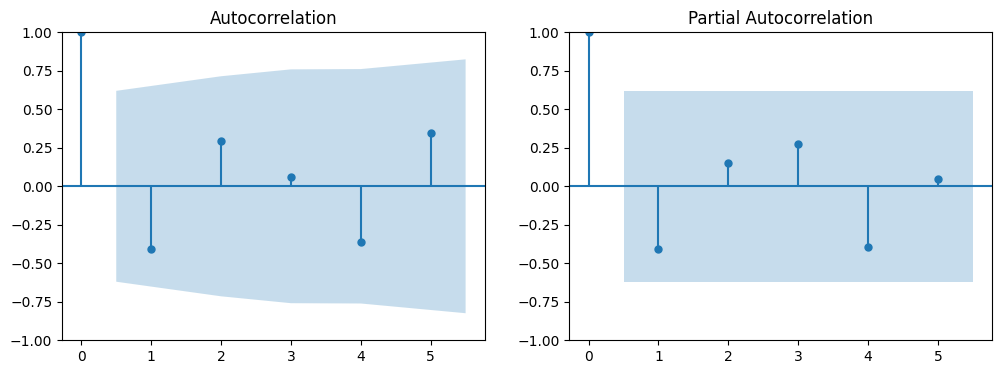

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use your crop data
tomato = ds[ds["Crop_Type"] == "Tomato"].groupby("Year")["Crop_Yield"].mean()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(tomato, lags=5, ax=axes[0])
plot_pacf(tomato, lags=5, ax=axes[1])
plt.show()

# The ACF (autocorrelation function) and PACF (partial autocorrelation function) are the classic way to choose AR (p) and MA (q).
# ACF → looks at correlations of the series with its own lags.
    # If you see a sharp cutoff → suggests an MA term.
# PACF → looks at correlations with lags after removing earlier lag effects.
    # If you see a sharp cutoff → suggests an AR term.

# How to interpret:
    # If PACF cuts off after lag 1 → try ARIMA(p=1, d=?, q=0).
    # If ACF cuts off after lag 1 → try ARIMA(p=0, d=?, q=1).
    # If both decay slowly → you may need differencing (d=1).


In [27]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm

def find_best_arima_orders(
    df, 
    group_col, 
    time_col, 
    target_col, 
    p_range=2, 
    d_range=2, 
    q_range=2, 
    verbose=False
):
    """
    Finds the best ARIMA(p,d,q) order per group in a dataset using AIC.

    Parameters
    ----------
    df : DataFrame
        The dataset containing time, target, and grouping columns.
    group_col : str
        Column name to group by (e.g., 'Crop_Type').
    time_col : str
        Column name for time (e.g., 'Year' or 'Date').
    target_col : str
        Column name for the target variable (e.g., 'Crop_Yield').
    p_range : int, default=2
        Max AR terms to test (tests range 0..p_range).
    d_range : int, default=2
        Max differencing terms to test (tests range 0..d_range).
    q_range : int, default=2
        Max MA terms to test (tests range 0..q_range).
    verbose : bool, default=False
        If True, prints progress for each group.

    Returns
    -------
    results_df : DataFrame
        DataFrame with best ARIMA orders per group (p,d,q, AIC, BIC, LogLik).
    """

    p = range(0, p_range+1)
    d = range(0, d_range+1)
    q = range(0, q_range+1)
    pdq = list(itertools.product(p, d, q))

    results_all = []

    for group in df[group_col].unique():
        series = df[df[group_col] == group].groupby(time_col)[target_col].mean()

        best_aic = np.inf
        best_params = None
        best_model = None

        for params in pdq:
            p, d, q = params
    
            # Skip if too many params for series length
            if (p + d + q) >= len(series) // 2:
                 continue
    
            try:
                model = sm.tsa.ARIMA(series, order=params)
                result = model.fit()
        
                # Skip if model failed to converge
                if not np.isfinite(result.aic) or not np.isfinite(result.bic):
                    continue

                aic = result.aic
                bic = result.bic
                llf = result.llf  # log likelihood

                if aic < best_aic:
                    best_aic = aic
                    best_params = params
                    best_model = result

            except Exception as e:
                continue

        # 🔹 Fallback if nothing worked
        if best_model is None:
            print(f"⚠️ Falling back to default ARIMA(0,1,0) for {group}")
            try:
                model = sm.tsa.ARIMA(series, order=(0,1,0))
                best_model = model.fit()
                best_params = (0,1,0)
                best_aic = best_model.aic
            except Exception:
                print(f"❌ Even fallback ARIMA failed for {group}")
                continue

        results_all.append({
            group_col: group,
            "Best_Order (p,d,q)": best_params,
            "AIC": best_aic,
            "BIC": best_model.bic if best_model else np.nan,
            "LogLik": best_model.llf if best_model else np.nan,
            "N_obs": len(series)
        })

        if verbose:
            print(f"{group}: Best order {best_params} (AIC={best_aic:.2f})")

    results_df = pd.DataFrame(results_all).sort_values("AIC").reset_index(drop=True)
    return results_df


In [23]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

def plot_arima_forecasts(
    df, 
    results_df, 
    group_col, 
    time_col, 
    target_col, 
    steps=3, 
    palette=None, 
    save_plots=False, 
    save_dir="ARIMA/plots", 
    show_combined=True
):
    """
    Plots ARIMA forecasts for each group using best orders from results_df.

    Parameters
    ----------
    df : DataFrame
        The dataset containing time, target, and grouping columns.
    results_df : DataFrame
        Output from find_best_arima_orders().
    group_col : str
        Column name to group by (e.g., 'Crop_Type').
    time_col : str
        Column name for time (e.g., 'Year').
    target_col : str
        Column name for the target variable (e.g., 'Crop_Yield').
    steps : int, default=3
        Forecast horizon.
    palette : list, optional
        Color palette for plots. Defaults to seaborn tab10.
    save_plots : bool, default=False
        If True, saves plots for each crop.
    save_dir : str, default="ARIMA/plots"
        Directory to save plots if save_plots=True.
    show_combined : bool, default=True
        If True, also shows all crops together on one plot.
    """

    crops = df[group_col].unique()
    if palette is None:
        palette = sns.color_palette("tab10", n_colors=len(crops))

    if save_plots:
        os.makedirs(save_dir, exist_ok=True)

    # Combined plot (all crops together)
    if show_combined:
        plt.figure(figsize=(14, 7))

    for i, crop in enumerate(crops):
        series = df[df[group_col] == crop].groupby(time_col)[target_col].mean()
        series.index = pd.to_datetime(series.index.astype(str))
        color = palette[i]

        if show_combined:
            plt.plot(series.index, series.values, label=f"{crop} (observed)", color=color)

        try:
            # Get best order from results_df
            best_order = results_df.loc[results_df[group_col] == crop, "Best_Order (p,d,q)"].values[0]

            model = ARIMA(series, order=best_order)
            results = model.fit()

            forecast_res = results.get_forecast(steps=steps)
            mean_forecast = forecast_res.predicted_mean
            conf_int = forecast_res.conf_int()

            # 🔹 Skip if forecast failed
            if mean_forecast.empty or conf_int.empty:
                print(f"⚠️ Skipping {crop}, forecast returned empty.")
                continue

            # Extend index for future predictions
            future_index = pd.date_range(
                start=series.index[-1] + pd.offsets.YearEnd(0),
                periods=steps, freq="YE"
            )

            # For printing numerical forecast
            for year, pred, lower, upper in zip(future_index, mean_forecast, conf_int.iloc[:,0], conf_int.iloc[:,1]):
                print(f"{crop} {year.year}: {pred:.2f} (95% CI: {lower:.2f} – {upper:.2f})")

            # Align forecast with series end
            forecast_index = [series.index[-1]] + list(future_index)
            forecast_values = [series.values[-1]] + list(mean_forecast)
            lower_ci = [series.values[-1]] + list(conf_int.iloc[:,0])
            upper_ci = [series.values[-1]] + list(conf_int.iloc[:,1])

            # Add to combined plot
            if show_combined:
                plt.plot(forecast_index, forecast_values, linestyle="--", marker="o", color=color, label=f"{crop} (forecast)")
                plt.fill_between(forecast_index, lower_ci, upper_ci, color=color, alpha=0.2)

                # Annotate last observed point
                plt.text(series.index[-1], series.values[-1], f"{series.values[-1]:.1f}", 
                          color=color, fontsize=8, ha="center", va="bottom")

                # Annotate forecasts
                for year, pred, lower, upper in zip(future_index, mean_forecast, conf_int.iloc[:,0], conf_int.iloc[:,1]):
                    plt.text(year, pred, f"{pred:.1f}", color=color, fontsize=8, ha="center", va="bottom")

            # Individual plot
            if save_plots:
                fig, ax = plt.subplots(figsize=(8, 5))
                ax.plot(series.index, series.values, label=f"{crop} (observed)", color=color)
                ax.plot(forecast_index, forecast_values, linestyle="--", marker="o", color=color, label=f"{crop} (forecast)")
                ax.fill_between(forecast_index, lower_ci, upper_ci, color=color, alpha=0.2)

                # Annotate last observed point
                plt.text(series.index[-1], series.values[-1], f"{series.values[-1]:.1f}", 
                         color=color, fontsize=8, ha="center", va="bottom")

                 # Annotate forecasts
                for year, pred, lower, upper in zip(future_index, mean_forecast, conf_int.iloc[:,0], conf_int.iloc[:,1]):
                    plt.text(year, pred, f"{pred:.1f}", color=color, fontsize=8, ha="center", va="bottom")

                ax.set_title(f"{crop} - ARIMA Forecast (Best Order {best_order})")
                ax.set_xlabel("Year")
                ax.set_ylabel(target_col)
                ax.legend()
                ax.grid(True)

                plt.savefig(os.path.join(save_dir, f"{crop}_arima_forecast.png"), dpi=300, bbox_inches="tight")
                plt.close()

        except Exception as e:
            print(f"ARIMA failed for {crop}: {e}")

    # Show combined plot
    if show_combined:
        plt.title("Crop Yields with Best-Fit ARIMA Forecasts")
        plt.xlabel("Year")
        plt.ylabel(target_col)
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, "Combined Crop Yields with Best-Fit ARIMA Forecasts.png"), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()


Wheat: Best order (3, 1, 0) (AIC=30.50)
Corn: Best order (1, 2, 0) (AIC=31.57)
Rice: Best order (2, 2, 0) (AIC=37.60)
Barley: Best order (0, 1, 0) (AIC=30.49)
Soybean: Best order (0, 0, 1) (AIC=25.13)
Cotton: Best order (0, 1, 0) (AIC=34.89)
Sugarcane: Best order (1, 1, 0) (AIC=33.34)
Tomato: Best order (2, 1, 1) (AIC=25.75)
Potato: Best order (0, 0, 3) (AIC=29.24)
Sunflower: Best order (4, 0, 0) (AIC=27.31)
Wheat 2023: 26.22 (95% CI: 24.91 – 27.54)
Wheat 2024: 27.23 (95% CI: 25.70 – 28.76)
Wheat 2025: 25.73 (95% CI: 24.09 – 27.37)
Corn 2023: 30.64 (95% CI: 28.14 – 33.14)
Corn 2024: 30.33 (95% CI: 26.39 – 34.27)
Corn 2025: 31.30 (95% CI: 24.84 – 37.75)
Rice 2023: 30.88 (95% CI: 28.01 – 33.76)
Rice 2024: 28.82 (95% CI: 24.08 – 33.56)
Rice 2025: 31.44 (95% CI: 25.50 – 37.37)
Barley 2023: 28.18 (95% CI: 25.87 – 30.49)
Barley 2024: 28.18 (95% CI: 24.91 – 31.45)
Barley 2025: 28.18 (95% CI: 24.18 – 32.18)
Soybean 2023: 25.74 (95% CI: 24.60 – 26.89)
Soybean 2024: 25.98 (95% CI: 24.44 – 27.53)

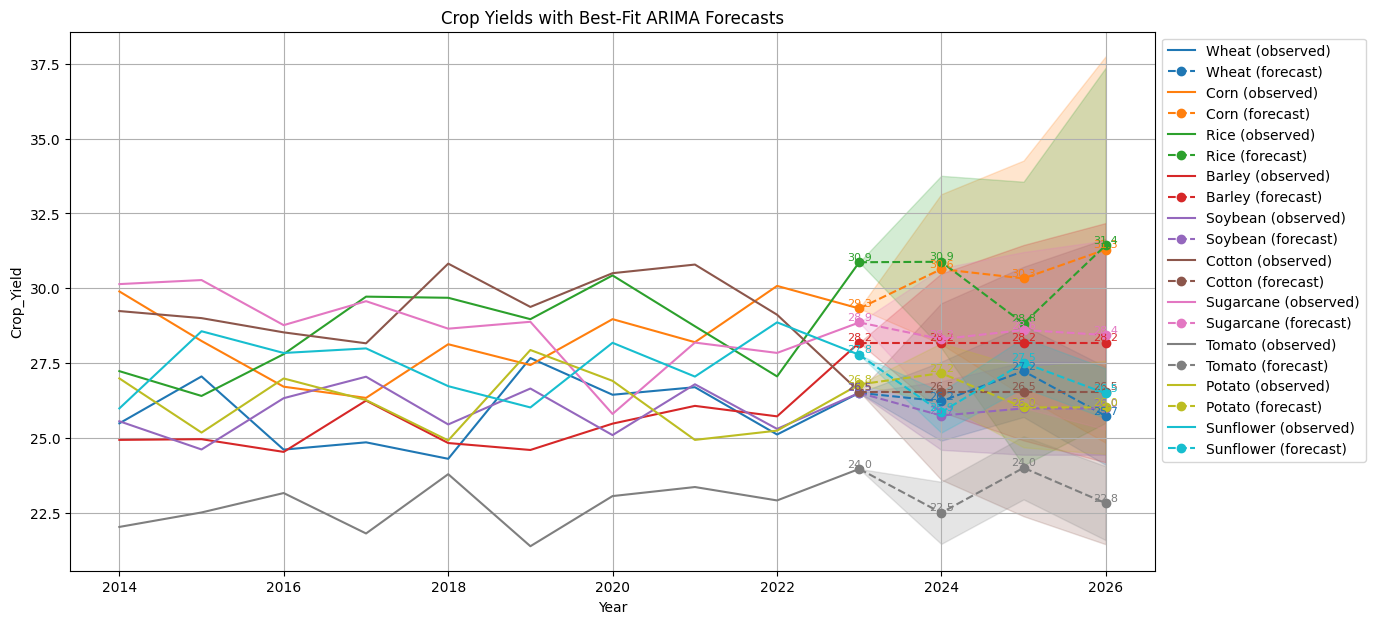

In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month

# Step 1: Find best ARIMA orders
results_df = find_best_arima_orders(
    ds, group_col="Crop_Type", time_col="Year", target_col="Crop_Yield", 
    p_range=4, d_range=4, q_range=4,
    verbose=True
)

# Step 2: Plot forecasts
plot_arima_forecasts(
    ds, results_df, 
    group_col="Crop_Type", time_col="Year", target_col="Crop_Yield", 
    steps=3, save_plots=True
)
